In [1]:
%matplotlib inline
import numpy as np
from math import sqrt
from numpy.linalg import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
def visualize(a,b,c):
    ax = axes3d.Axes3D(plt.figure())
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = a * np.outer(np.cos(u), np.sin(v))
    y = b * np.outer(np.sin(u), np.sin(v))
    z = b * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z,  rstride=4, cstride=4)
    plt.show()
    return 0

In [3]:
### SETTINGS
MAX_COUNT_ITER = 1000
EPS = 10**(-5)
DIM = 3
h = np.array([0.001, 0.001, 0.001], dtype = float)

###CONSTRAINTS for ellipsoid x^2/a^2 + y^2/b^2 + z^2/c^2 <= 1
A = 3.0   #actually it's a^2
B = 2.0   #actually it's b^2
C = 1.0   #actually it's c^2

### TARGET FUNCTIONS
f_type = 'nonquadratic'
if (f_type == 'quadratic'):
    A = np.array([[2, 0.001], [0.001, 8]], dtype = float)
    b = np.array([0, -1], dtype = float)

def f_myvar(x):
    return x[0]**2 + 4.0 * x[1]**2 + 0.01 * x[0] * x[1] - x[1]

def f_test(x):
    return x[0]**2 + 4.0 * x[1]**2 + 0.01 * x[0] * x[1] - x[1]

f = f_test
x0 = np.array([-2, -3, -7], dtype = float)

In [4]:
def df1(f,x,h):
    return (f([x[0] + h, x[1]]) - f([x[0] - h, x[1]])) / (2.0 * h)
def df2(f,x,h):
    return (f([x[0], x[1] + h]) - f([x[0], x[1] - h])) / (2.0 * h)

def grad(f,x,h):
    return np.array([df1(f,x,h[0]), df2(f,x,h[1])], dtype = float)


#def grad(f,x,h):
#    I = np.eye(len(x))
#    return np.array([(f(x + h * I_) - f(x - h * I_))/(2.0*h) for I_ in I])


def alpha_split(f,x,step,b=1,l=0.5,q=0.1):
    alpha = b
    #while (f(x+alpha*step) >= f(x)):
    while f(x+alpha*step) > f(x) + q * alpha * grad(f,x,h).dot(step):
        alpha *= l
    #print(alpha)
    return alpha

### STOP CONDITIONS
def stop1(x1,x2,k):
    d = norm(x2-x1)
    plt.xlabel('iteration')
    plt.ylabel('|| x_new - x_old || ')
    plt.scatter(k, d)
    return d<=EPS

def stop2(f,x1,x2,k):
    d = abs(f(x2)-f(x1))
    plt.xlabel('iteration')
    plt.ylabel('| f(x_new) - f(x_old) | ')    
    plt.scatter(k, d)
    return d<=EPS

SyntaxError: EOL while scanning string literal (<ipython-input-4-8891d2aa59ff>, line 13)

# Метод спряжених напрямів першого порядку


Approximate solution found in 10 iterations
> Approximate   x*  = (-0.25503, -0.57382, -0.38255)
> Approximate f(x*) = -2.61406


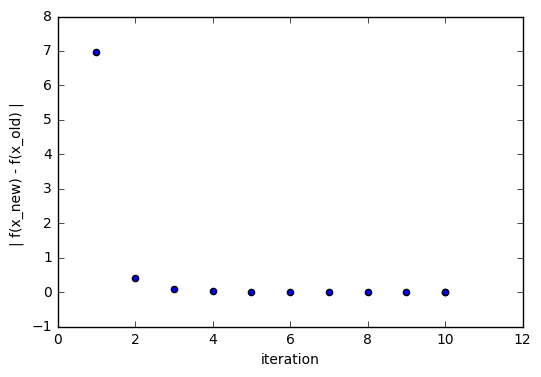

In [26]:
def conjugate_directions_first(x0,h):
    fout = open('output.txt', 'w')
    fout.write('The initial point is ({x}, {y})\n\n'.format(x=x0[0], y=x0[1]))
    x_new = x0
    step_new = - grad(f,x_new,h)
    k = 0
    plt.xlabel('iteration')
    while (k<MAX_COUNT_ITER):
        x_old = x_new  
        step_old = step_new
        beta = df(x_old,h)
        step_new = - grad(f,x_old,h) + beta * step_old
        alpha = choose_alpha_method(x_old,step,f_type)
        x_new = x_old + alpha * step
        k += 1 
        fout.write('{iter:>3}. alpha = {al:<17.15f},   x_{iter:<3} = ({x:>18.15f}, {y:>18.15f})\n'.format(iter=k, x=x_new[0], y=x_new[1], al=alpha))
        #print('{iter:>3}. alpha = {al:<17.15f},   x_{iter:<3} = ({x:>18.15f}, {y:>18.15f})'.format(iter=k, x=x_new[0], y=x_new[1], al=alpha))
        if (stop1(x_old,x_new,k)):    ### STOP CONDITION 1
        #if (stop2(x_old,x_new,k)):    ### STOP CONDITION 2
        #if (stop3(x_new,h,k)):        ### STOP CONDITION 3
            break
    print('Gradient method found approximate solution in {} iterations'.format(k))
    fout.write('\nThe approximate solution of the problem is ({x:>10.7f}, {y:>10.7f})\n'.format(x=x_new[0], y=x_new[1]))
    fout.write('The value of function in this point is {v:>10.7f}\n'.format(v=f(x_new)))
    fout.close()
    return x_new

minim = projection_gradient_method(f,x0,h)
plt.show()
print()

# МЕТОД ПРОЕКЦІЇ ГРАДІЄНТА З ФОРМУЛОЮ ДЛЯ ОБЧИСЛЕННЯ ПРОЕКЦІЇ


Approximate solution found in 9 iterations
> Approximate   x*  = (-0.29916, -0.56871, -0.29094)
> Approximate f(x*) = -2.59539
0.0186721721328


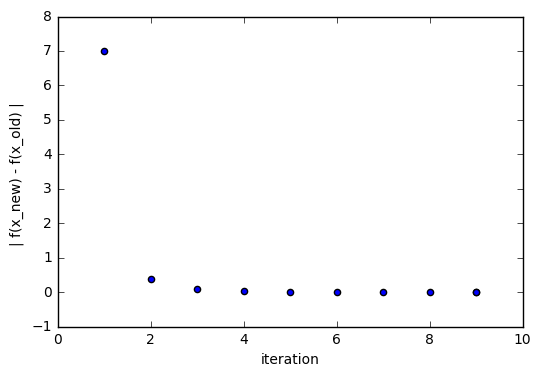

In [28]:
def projection_gradient_method_f(f,x0,h):
    fout = open('output.txt', 'w')
    fout.write('The initial point is ({}, {}, {})\n\n'.format(*x0))
    x_new = x0
    k = 0
    while (k<MAX_COUNT_ITER):
        k += 1 
        x_old = x_new    
        step = - grad(f,x_old,h)
        alpha = alpha_split(f,x_old,step)
        t = x_old + alpha * step
        fout.write('{iter:>3}. alpha = {al:<5.3f},   x_{iter:<3} = ({:>7.4f}, {:>7.4f}, {:>7.4f}),   '.format(iter=k, *t, al=alpha))
        x_new = my_projection_ellipsoid(t)
        fout.write('prx_{iter:<3} = ({:>7.4f}, {:>7.4f}, {:>7.4f}),   f(x_{iter:<}) = {f:>7.4f}\n'.format(iter=k, *x_new, f=f(x_new)))
        if (stop1(x_old,x_new,k) and stop2(f,x_old,x_new,k)):
            break
    print('Approximate solution found in {} iterations'.format(k))
    print('> Approximate   x*  = ({:>8.5f}, {:>8.5f}, {:>8.5f})'.format(*x_new))
    print('> Approximate f(x*) = {:>8.5f}'.format(f(x_new)))
    fout.write('\nThe approximate solution of the problem is ({:>8.5f}, {:>8.5f}, {:>8.5f})\n'.format(*x_new))
    fout.write('The value of function in this point is {:>8.5f}\n'.format(f(x_new)))
    fout.close()
    print(abs(f(x_new)+sqrt(41.0/6)))
    return x_new

minim = projection_gradient_method_f(f,x0,h)
plt.show()
print()